This notebook provides the framework for doing the batch transform for hourly call volume predictions using NFORS data. The cells at the beginning of the notebook are all required for running the code, but the end of the notebook contains the code I used for creating the datasets for reference.

In [1]:
#If running in local mode, local to True. Otherwise, set it to false
local = False

# Getting the Sagemaker role

In [2]:
import sagemaker
from sagemaker import get_execution_role

# S3 prefix
prefix = 'hourly_call_volume'


if local == True:
    sagemaker_session = sagemaker.LocalSession()
    role = 'arn:aws:iam::445861113736:role/service-role/AmazonSageMaker-ExecutionRole-20190903T114521'
else:
    sagemaker_session = sagemaker.Session()
    role = get_execution_role()

## Create SageMaker Scikit Estimator <a class="anchor" id="create_sklearn_estimator"></a>

To run our Scikit-learn training script on SageMaker, we construct a `sagemaker.sklearn.estimator.sklearn` estimator, which accepts several constructor arguments:

* __entry_point__: The path to the Python script SageMaker runs for training and prediction.
* __role__: Role ARN
* __train_instance_type__ *(optional)*: The type of SageMaker instances for training. __Note__: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
* __sagemaker_session__ *(optional)*: The session used to train on Sagemaker.
* __hyperparameters__ *(optional)*: A dictionary passed to the train function as hyperparameters.

To see the code for the SKLearn Estimator, see here: https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/sklearn

In [4]:
from sagemaker.sklearn.estimator import SKLearn

script_path = 'hourly_call_prediction.py'
sklearn = SKLearn(
    entry_point=script_path,
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session,
    hyperparameters={'n_estimators': 1000})

## Train SKLearn Estimator on call volume data

In [5]:
#The data should already be saved to the ./data directory
WORK_DIRECTORY = 'data'
train_input = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

#Training the model
sklearn.fit({'train': train_input})

2020-01-22 18:59:30 Starting - Starting the training job...
2020-01-22 18:59:32 Starting - Launching requested ML instances...
2020-01-22 19:00:27 Starting - Preparing the instances for training......
2020-01-22 19:01:28 Downloading - Downloading input data
2020-01-22 19:01:28 Training - Downloading the training image..2020-01-22 19:01:43,901 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-01-22 19:01:43,903 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-01-22 19:01:43,914 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-01-22 19:01:44,178 sagemaker-containers INFO     Module hourly_call_prediction does not provide a setup.py. 
Generating setup.py
2020-01-22 19:01:44,178 sagemaker-containers INFO     Generating setup.cfg
2020-01-22 19:01:44,178 sagemaker-containers INFO     Generating MANIFEST.in
2020-01-22 19:01:44,178 sagemaker-containers INFO     Installing module with the 

## Batch Transform <a class="anchor" id="batch_transform"></a>
We can also use the trained model for asynchronous batch inference on S3 data using SageMaker Batch Transform.

In [6]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
transformer = sklearn.transformer(instance_count=1, instance_type='ml.m4.xlarge')

### Run Transform Job <a class="anchor" id="run_transform_job"></a>
Using the Transformer, run a transform job on the S3 input data.

In [7]:
#Again, the test data should already be saved to the prediction_data directory
WORK_DIRECTORY = 'prediction_data'
batch_input_s3 = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

# Start a transform job and wait for it to finish
transformer.transform(batch_input_s3, content_type='text/csv',  join_source='Input')
print('Waiting for transform job: ' + transformer.latest_transform_job.job_name)
transformer.wait()

Waiting for transform job: sagemaker-scikit-learn-2020-01-22-19-04-27-675
........................
Processing /opt/ml/code
  Created wheel for hourly-call-prediction: filename=hourly_call_prediction-1.0.0-py2.py3-none-any.whl size=7375 sha256=a2f200f7dc03df0ec28ae20fcc0163a6c3e5bde4b6709198dc29582c6587236c
  Stored in directory: /tmp/pip-ephem-wheel-cache-7fpiuyfn/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built hourly-call-prediction
/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
[2020-01-22 19:08:07 +0000] [37] [INFO] Starting gunicorn 19.9.0
[2020-01-22 19:08:07 +0000] [37] [INFO] Listening at: unix:/tmp/gunicorn.sock (37)
[2020-01-22 19:08:07 +0000] [37] [INFO] Using worker: gevent
[2020-01-22 19:08:07 +0000] [40] [INFO] Booting worker with pid: 40
[20

In [ ]:
trans

# Exporting prediction results as json

In [62]:
import json
import pandas as pd

# Download the output data from S3 to local filesystem
batch_output = transformer.output_path
!mkdir -p batch_data/output
!aws s3 cp --recursive $batch_output/ batch_data/output/

#Loading the predictions and appending them to 
with open('./batch_data/output/test_data.json.out', 'r') as file:
    pred = file.read()
pred = pred.strip('][').split(', ')
pred = [float(i) for i in pred]


#Loading the test dataframe so we can append the results to it
with open('./prediction_data/test_data.json') as datafile:
    data = json.load(datafile)
results = pd.io.json.json_normalize(data['prediction_data'])
results['call_volume'] = pred


#Saving it as a json
jsondata = {}
jsondata['model_name'] = 'calls_by_hour'
jsondata['model_version'] = 1.0
jsondata['results'] = results.to_dict(orient='records')

with open('./prediction_data/results.json', 'w') as outfile:
    json.dump(jsondata,outfile)


download: s3://sagemaker-us-east-2-445861113736/sagemaker-scikit-learn-2020-01-22-19-04-27-675/test_data.json.out to batch_data/output/test_data.json.out


# Example plots

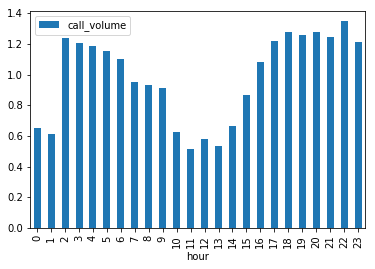

In [86]:
import matplotlib.pyplot as plt
day = 'Friday'
fc_id = '79592'




subset = results[ (results['fire_department.firecares_id'] == fc_id) & (results['description.day_of_week'] == day)]
subset.plot.bar('hour', 'call_volume')

# Creating the training data and uploading to s3
This cell only works locally because it depends on elasticsearch.


In [ ]:
#Importing libraries required for performing the query
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
from elasticsearch_dsl import Q
import pandas as pd
import json

#Setting up the query
es = Elasticsearch()
s = Search(using=es,index='*-fire-incident-*')
s = s.source(['description.event_opened',
                     'description.day_of_week',
                    'NFPA.type',
                     'fire_department.firecares_id'])


#Performing the query
q = Q("match",fire_department__firecares_id =  '79592') | Q("match",fire_department__firecares_id =  '93345')
results = s.query(q)

#Converting query results to a pandas dataframe
df = pd.DataFrame((d.to_dict() for d in tqdm_notebook(results.scan())))
json_struct = json.loads(df.to_json(orient="records"))

df = pd.io.json.json_normalize(json_struct)

#Converting date
df['date'] = df['description.event_opened'].apply(lambda x: x[:10])
df['month'] = df.apply(lambda x: x['date'][5:7], axis=1)
df['hour'] = df['description.event_opened'].apply(lambda x: x[11:13])


#Converting df dates to datetime objects
df['date'] = df.apply(lambda x: datetime.datetime.strptime(x['date'],'%Y-%m-%d'),axis=1)
# df['date'] = df.apply(lambda x: datetime.datetime.strptime(x['date'],'%Y-%m-%d'),axis=1)

#It's convenient to serialize (pickle) the dataframe because it's faster to load it rather than re-create it.
df.to_pickle('query_results')

#Hourly is a dataframe aggregated grouped by the day, hour, and department
hourly = df[['fire_department.firecares_id', 'date','description.day_of_week', 'hour']].groupby(['fire_department.firecares_id', 'date','description.day_of_week', 'hour']).aggregate(len).reset_index()
hourly = hourly.rename(columns={0: 'calls'})

#Formatting the hourly dataframe into a json
jsondata = {}
jsondata['model_name'] = 'calls_by_hour'
jsondata['model_version'] = 1.0
jsondata['prediction_data'] = hourly.drop('date',axis=1).to_dict(orient='records')

#Saving the json to the data directory
with open('./data/training_data.json', 'w') as outfile:
    json.dump(jsondata, outfile)
    


# Creating the test dataset
This involves generating a dataframe with every possible combination of department, day of week, and hour of the day. The size of this dataset is 7x24xn, where n is the number of departments included for predictions.

Also, this cell requires that the training set has already been created.

In [97]:
#Make every combination of departments, days of week, and hour
from itertools import product
import json
import pandas as pd



#load the training dataset
with open('./data/training_data.json') as data_file:
    data = json.load(data_file)
hourly = pd.io.json.json_normalize(data['prediction_data'])

#Getting the list of ever department that shows up in the hourly dataframe
dep_list = hourly['fire_department.firecares_id'].unique()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hours = [str(i).zfill(2) for i in range(24)]

#Creating the dataframe of all possible combinations
test_df = pd.DataFrame(list(product(dep_list, days, hours)), columns=['fire_department.firecares_id', 'description.day_of_week', 'hour'])

#Saving it as a csv
test_df.to_csv('./prediction_data/test_data')


